<a href="https://colab.research.google.com/github/wdon021/From_Colab/blob/master/COmp421_Assignment2_part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits import mplot3d
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow import keras
import keras.backend as kb
import tensorflow as tf
from tensorflow.keras import layers
import datetime
from numpy import linalg as LA

In [3]:
mean = [0, 0]
cov = [[1, 0],
       [0, 1]]
united = np.random.multivariate_normal(mean, cov, 4000)       

In [4]:
n = 4000
xy_min = [0, 0]
xy_max = [1, 1]
data = np.random.uniform(low = xy_min, high = xy_max, size=(n, 2))

In [5]:
@tf.function
def different_kernel(X,Y, lamb):
  z1 = tf.expand_dims(X, 0)
  z2 = tf.expand_dims(Y, 1)
  return (tf.reduce_sum(tf.exp(-tf.reduce_sum(tf.math.squared_difference(z1, z2),axis= -1)/lamb)))/(len(X)*(len(Y)))

In [6]:
@tf.function
def same_kernels(X, lamb):
  z1 = tf.expand_dims(X, 0)
  z2 = tf.expand_dims(X, 1)
  return (tf.reduce_sum(tf.exp(-tf.reduce_sum(tf.math.squared_difference(z1, z2),axis= -1)/lamb))-len(X))/(len(X)*(len(X)-1))

In [7]:
@tf.function
def MMD(X, Y, lam):
  return same_kernels(X, lam)+same_kernels(Y, lam)-(2*(different_kernel(X, Y, lam)))

In [8]:
# training dataset
batch_size = 100
optimizer = tf.keras.optimizers.Adam(0.001)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(united, data, test_size = 0.25)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.25)
X_train = tf.cast(X_train, tf.float32)
Y_train = tf.cast(Y_train, tf.float32)
X_val = tf.cast(X_val, tf.float32)
Y_val = tf.cast(Y_val, tf.float32)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(buffer_size= 3000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val)).shuffle(1000).batch(batch_size)

In [10]:
X_train_f2a, X_test_f2a, Y_train_f2a, Y_test_f2a = train_test_split(data, united, test_size = 0.25)
X_train_f2a, X_val_f2a, Y_train_f2a, Y_val_f2a = train_test_split(X_train_f2a, Y_train_f2a, test_size = 0.25)
X_train_f2a = tf.cast(X_train_f2a, tf.float32)
Y_train_f2a = tf.cast(Y_train_f2a, tf.float32)
X_val_f2a = tf.cast(X_val_f2a, tf.float32)
Y_val_f2a = tf.cast(Y_val_f2a, tf.float32)
train_dataset_f2a = tf.data.Dataset.from_tensor_slices((X_train_f2a, Y_train_f2a)).shuffle(buffer_size= 3000).batch(batch_size)
val_dataset_f2a = tf.data.Dataset.from_tensor_slices((X_val_f2a, Y_val_f2a)).shuffle(1000).batch(batch_size)

### No regularization concatenate f1 with f_2a

In [61]:
inputs = keras.Input(shape = (2,))
x1 = layers.Dense(15, activation="sigmoid")(inputs)
x2 = layers.Dense(15, activation='sigmoid')(x1)
outputs = layers.Dense(2, activation='linear')(x2)
model_f1 = keras.Model(inputs = inputs, outputs = outputs)
epochs = 800
radius = 8
for epoch in range(epochs):
  # print("\nStart of epoch########################################### %d \n" % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

    # open a GradientTape to record the operations run during the feed forward
    # enables aoto-partial-Differentiation
    with tf.GradientTape() as tape:
      # run the feed foward process of the layers.
      # the operations that the layers apply to its inpurts and going to bee recorded on the GradientTape
      linear = model_f1(x_batch_train, training = True)

      MMD_loss = MMD(linear, y_batch_train, tf.cast(radius, tf.float32))
    grads = tape.gradient(MMD_loss, model_f1.trainable_weights)

    # weight + bias for every layer
    # run one step of gradient dscent by updating the value of the variables to minize the loss
    optimizer.apply_gradients(zip(grads, model_f1.trainable_weights))

In [34]:
X_rest = X_test[~((X_test[:,0] <= -1) & (X_test[:,1]<= -1))]
X_takes = X_test[(X_test[:,0] <= -1) & (X_test[:,1]<= -1)]
X_have = X_test[(X_test[:,0] >= 2) & (X_test[:,1]>= 1)]

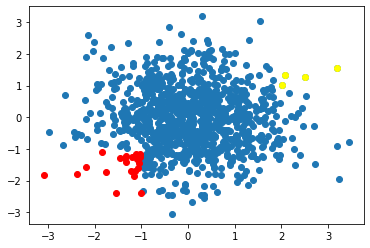

In [36]:
xx1, xx2 = X_rest.T
z1, z2 = X_takes.T
dz1, dz2 = X_have.T
fig = plt.figure()
ax = plt.axes()
ax.plot(xx1, xx2, 'o')
ax.plot(z1, z2, 'o',c ='red')
ax.plot(dz1, dz2, 'o',c ='yellow')

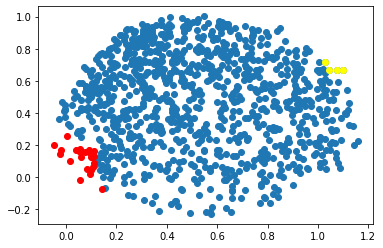

In [63]:
f1_out_rest = model_f1.predict(X_rest)
f1_out_take = model_f1.predict(X_takes)
f1_out_X_have = model_f1.predict(X_have)
xx1, xx2 = f1_out_rest.T
z1, z2 = f1_out_take.T
c1, c2 = f1_out_X_have.T
fig = plt.figure()
ax = plt.axes()
ax.plot(xx1, xx2, 'o')
ax.plot(z1, z2, 'o',c ='red')
ax.plot(c1, c2, 'o',c ='yellow')

In [67]:
radius = 10
optimizer = tf.keras.optimizers.Adam(0.001)
inputs = keras.Input(shape = (2,))
x1 = layers.Dense(20, activation="relu")(inputs)
x2 = layers.Dense(20, activation='relu')(x1)
outputs = layers.Dense(2, activation='linear')(x2)
model_fa2 = keras.Model(inputs = inputs, outputs = outputs)
epochs = 1000
for epoch in range(epochs):
  # print("\nStart of epoch########################################### %d \n" % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset_f2a):

    # open a GradientTape to record the operations run during the feed forward
    # enables aoto-partial-Differentiation
    with tf.GradientTape() as tape:
      # run the feed foward process of the layers.
      # the operations that the layers apply to its inpurts and going to bee recorded on the GradientTape
      linear = model_fa2(x_batch_train, training = True)
      MMD_loss = MMD(linear, Y_train_f2a, tf.cast(radius, tf.float32))
    grads = tape.gradient(MMD_loss, model_fa2.trainable_weights)
    # print(grads)
    # weight + bias for every layer
    # run one step of gradient dscent by updating the value of the variables to minize the loss
    optimizer.apply_gradients(zip(grads, model_fa2.trainable_weights))

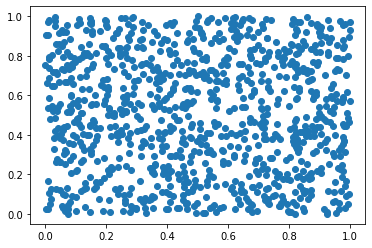

In [68]:
px1, px2 = X_test_f2a.T
fig = plt.figure()
ax = plt.axes()
ax.plot(px1, px2, 'o')

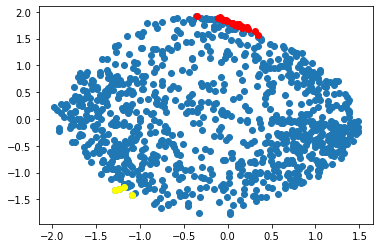

In [72]:
fa2_r_out_rest = model_fa2.predict(f1_out_rest)
fa2_r_out_take = model_fa2.predict(f1_out_take)
fa2_r_out_have = model_fa2.predict(f1_out_X_have)
xx1, xx2 = fa2_r_out_rest.T
z1, z2 = fa2_r_out_take.T
c1, c2 = fa2_r_out_have.T
fig = plt.figure()
ax = plt.axes()
ax.plot(xx1, xx2, 'o')
ax.plot(z1, z2, 'o',c ='red')
ax.plot(c1, c2, 'o',c ='yellow')

### regularization concatenate f1 with f_2a

In [52]:
radius = 8
# lamda = 0.00001
lamda = 0.0000001 
inputs = keras.Input(shape = (2,))
x1 = layers.Dense(10, activation="sigmoid")(inputs)
x2 = layers.Dense(10, activation='sigmoid')(x1)
outputs = layers.Dense(2, activation='linear')(x2)
model_f1_r = keras.Model(inputs = inputs, outputs = outputs)
epochs = 800

for epoch in range(epochs):
  # print("\nStart of epoch########################################### %d \n" % (epoch,))

# Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

    # open a GradientTape to record the operations run during the feed forward
    # enables aoto-partial-Differentiation
    with tf.GradientTape() as tape:
      # run the feed foward process of the layers.
      # the operations that the layers apply to its inpurts and going to bee recorded on the GradientTape
      linear = model_f1_r(x_batch_train, training = True)
      weights_sum = [tf.reduce_sum(tf.square(w)) for w in model_f1_r.trainable_weights if 'bias' not in w.name] # exclude bias term
      MMD_loss = MMD(linear, y_batch_train, tf.cast(radius, tf.float32))
      # print(MMD_loss)
      MMD_loss_regu = MMD_loss + lamda*tf.reduce_sum(weights_sum)
      # print(MMD_loss_regu)
    grads = tape.gradient(MMD_loss_regu, model_f1_r.trainable_weights)
    # print(grads)
    # weight + bias for every layer
    # run one step of gradient dscent by updating the value of the variables to minize the loss
    optimizer.apply_gradients(zip(grads, model_f1_r.trainable_weights))


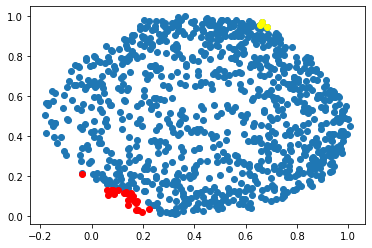

In [53]:
f1_r_out_rest = model_f1_r.predict(X_rest)
f1_r_out_take = model_f1_r.predict(X_takes)
f1_r_out_have = model_f1_r.predict(X_have)
xx1, xx2 = f1_r_out_rest.T
z1, z2 = f1_r_out_take.T
c1, c2 = f1_r_out_have.T
fig = plt.figure()
ax = plt.axes()
ax.plot(xx1, xx2, 'o')
ax.plot(z1, z2, 'o',c ='red')
ax.plot(c1, c2, 'o',c ='yellow')

In [59]:
radius = 10
# lamda = 0.000001
lamda =  0.0000001 
inputs = keras.Input(shape = (2,))
x1 = layers.Dense(10, activation="relu")(inputs)
x2 = layers.Dense(10, activation='relu')(x1)
outputs = layers.Dense(2, activation='linear')(x2)
model_f2a_r = keras.Model(inputs = inputs, outputs = outputs)
epochs = 1200

training_mmd = np.array([])
valid_mmd = np.array([])
KL = np.array([])
for epoch in range(epochs):
  # print("\nStart of epoch########################################### %d \n" % (epoch,))

# Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset_f2a):

    # open a GradientTape to record the operations run during the feed forward
    # enables aoto-partial-Differentiation
    with tf.GradientTape() as tape:
      # run the feed foward process of the layers.
      # the operations that the layers apply to its inpurts and going to bee recorded on the GradientTape
      linear = model_f2a_r(x_batch_train, training = True)

      weights_sum = [tf.reduce_sum(tf.square(w)) for w in model_f2a_r.trainable_weights if 'bias' not in w.name] # exclude bias term

      MMD_loss = MMD(linear, Y_train_f2a, tf.cast(radius, tf.float32))
      # print(MMD_loss)
      MMD_loss_regu = MMD_loss + lamda*tf.reduce_sum(weights_sum)
      # print(MMD_loss_regu)
    grads = tape.gradient(MMD_loss_regu, model_f2a_r.trainable_weights)
    # print(grads)
    # weight + bias for every layer
    # run one step of gradient dscent by updating the value of the variables to minize the loss
    optimizer.apply_gradients(zip(grads, model_f2a_r.trainable_weights))

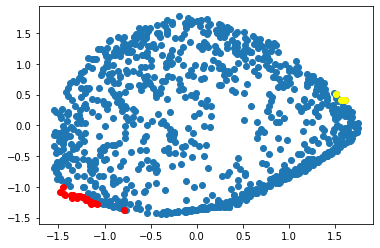

In [60]:
f2a_r_out_rest = model_f2a_r.predict(f1_r_out_rest)
f2a_r_out_take = model_f2a_r.predict(f1_r_out_take)
f2a_r_out_have = model_f2a_r.predict(f1_r_out_have)
xx1, xx2 = f2a_r_out_rest.T
z1, z2 = f2a_r_out_take.T
cc1, cc2 = f2a_r_out_have.T
fig = plt.figure()
ax = plt.axes()
ax.plot(xx1, xx2, 'o')
ax.plot(z1, z2, 'o',c ='red')
ax.plot(cc1, cc2, 'o',c ='yellow')

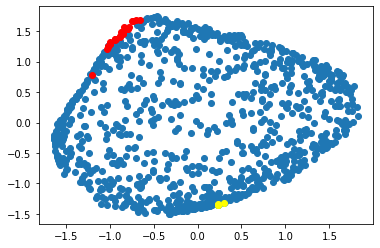

In [58]:
f2a_r_out_rest = model_f2a_r.predict(f1_r_out_rest)
f2a_r_out_take = model_f2a_r.predict(f1_r_out_take)
f2a_r_out_have = model_f2a_r.predict(f1_r_out_have)
xx1, xx2 = f2a_r_out_rest.T
z1, z2 = f2a_r_out_take.T
cc1, cc2 = f2a_r_out_have.T
fig = plt.figure()
ax = plt.axes()
ax.plot(xx1, xx2, 'o')
ax.plot(z1, z2, 'o',c ='red')
ax.plot(cc1, cc2, 'o',c ='yellow')